# Tabular project 1: Emotion classification from image features extracted using CLIP image encoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Prepare dataset

Dataset description:
*   Dataset contain 776 .npy files and 1 .txt file (id_list.txt)
*   Files XXX_semantic.npy save several images features has labels in file XXX_emotion.npy. Example: files 001_semantic.npy save an array of (288, 768) which means there are 288 images each image has feature as a vector of 768 elements. Therefore, file 001_emotion.npy save an array of (288, ) as 288 labels for each image features
*   Each sample has 768 features will be classify into 6 classes


In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1NuydJYXtLRsAI-eDqHhLXE9UOjqFAkT0

Downloading...
From (original): https://drive.google.com/uc?id=1NuydJYXtLRsAI-eDqHhLXE9UOjqFAkT0
From (redirected): https://drive.google.com/uc?id=1NuydJYXtLRsAI-eDqHhLXE9UOjqFAkT0&confirm=t&uuid=6f6b9672-f026-4223-83a3-d3b11c7bd8f6
To: /content/dataset_semantic_emotion.zip
100% 142M/142M [00:02<00:00, 65.3MB/s]


In [ ]:
!unzip /content/dataset_semantic_emotion.zip
!rm -rf /content/dataset_semantic_emotion.zip

Archive:  /content/dataset_semantic_emotion.zip
   creating: dataset_semantic_emotion/
  inflating: dataset_semantic_emotion/001_emotion.npy  
  inflating: dataset_semantic_emotion/001_semantic.npy  
  inflating: dataset_semantic_emotion/002_emotion.npy  
  inflating: dataset_semantic_emotion/002_semantic.npy  
  inflating: dataset_semantic_emotion/003_emotion.npy  
  inflating: dataset_semantic_emotion/003_semantic.npy  
  inflating: dataset_semantic_emotion/004_emotion.npy  
  inflating: dataset_semantic_emotion/004_semantic.npy  
  inflating: dataset_semantic_emotion/005_emotion.npy  
  inflating: dataset_semantic_emotion/005_semantic.npy  
  inflating: dataset_semantic_emotion/006_emotion.npy  
  inflating: dataset_semantic_emotion/006_semantic.npy  
  inflating: dataset_semantic_emotion/007_emotion.npy  
  inflating: dataset_semantic_emotion/007_semantic.npy  
  inflating: dataset_semantic_emotion/008_emotion.npy  
  inflating: dataset_semantic_emotion/008_semantic.npy  
  inflati

In [ ]:
id_list_file_path = '/content/dataset_semantic_emotion/id_list.txt'
with open(id_list_file_path, 'r') as f:
    id_list = f.readline()

id_list = id_list.split(',')
print(id_list)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '035', '036', '037', '038', '039', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147'

Read data

In [ ]:
import numpy as np

semantic_feature_list = [] # List of numpy array shape (X, 768)
emotion_list = [] # List of numpy array shape (X, )
for id in id_list:
    semantic_file_path = '/content/dataset_semantic_emotion/' + id + '_semantic.npy'
    emotion_file_path = '/content/dataset_semantic_emotion/' + id + '_emotion.npy'

    semantic_feature = np.load(semantic_file_path)
    emotion = np.load(emotion_file_path)

    # Remove some last sample in order to has the number of sample equal the number of label
    if semantic_feature.shape[0] != emotion.shape[0]:
        # print(f'Alert {id}, {semantic_feature.shape} <> {emotion.shape}')
        min_len = min(semantic_feature.shape[0], emotion.shape[0])
        semantic_feature = semantic_feature[:min_len]
        emotion = emotion[:min_len]

    semantic_feature_list.append(semantic_feature)
    emotion_list.append(emotion)

X = torch.tensor(np.vstack(semantic_feature_list))
y = torch.tensor(np.hstack(emotion_list))
print(X.shape)
print(y.shape)

torch.Size([100104, 768])
torch.Size([100104])


In [ ]:
# Print first sample
print(X[0])
print(y[0])

tensor([ 1.5210e-01, -5.2441e-01,  2.7222e-01, -1.3896e+00, -1.7346e-01,
        -2.8784e-01, -2.8101e-01,  4.6460e-01,  8.0750e-02, -1.0068e+00,
        -3.0127e-01, -3.5718e-01,  1.4351e-02,  1.2299e-01, -5.8936e-01,
        -1.8408e-01, -3.6719e-01, -7.4170e-01,  3.6591e-02, -2.6733e-01,
        -1.7053e-01, -1.6858e-01,  2.8296e-01, -8.4375e-01, -5.9863e-01,
        -5.6201e-01,  1.5747e-01,  3.2520e-03, -3.0420e-01,  8.7012e-01,
        -6.0107e-01,  6.0449e-01, -9.3140e-02, -5.4541e-01,  3.4454e-02,
         2.5928e-01, -4.8584e-01,  7.3792e-02, -1.0098e+00, -5.5127e-01,
        -1.5356e-01,  1.8616e-01,  3.3643e-01, -4.8943e-03,  2.0398e-01,
         3.9160e-01,  8.4863e-01,  3.3667e-01, -9.2627e-01, -4.8877e-01,
        -2.5122e-01,  3.4790e-01, -2.8271e-01,  6.9031e-02,  4.1675e-01,
        -7.1924e-01,  4.9170e-01,  1.8762e-01,  1.1847e-01, -4.1504e-01,
         3.3569e-01,  3.2251e-01, -4.5654e-01, -3.6377e-02, -8.8501e-02,
        -2.0569e-01,  9.9170e-01,  1.7383e-01, -5.9

In [ ]:
for i in range(6):
    print(f'Class {i}: {torch.sum(y == i).item()}')

Class 0: 16671
Class 1: 21541
Class 2: 28513
Class 3: 22617
Class 4: 6847
Class 5: 3915


Preprocessing data

In [ ]:
one_hot_dict = F.one_hot(torch.arange(0, 6), num_classes=6)
print(one_hot_dict)

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]])


In [ ]:
# Encode class name into one-hot vector
y_one_hot = [one_hot_dict[i] for i in y]
y_one_hot = torch.vstack(y_one_hot).float().to(device)

print(y_one_hot[0])
print(y_one_hot.shape)
print(y_one_hot.dtype)

tensor([0., 0., 0., 0., 1., 0.], device='cuda:0')
torch.Size([100104, 6])
torch.float32


In [ ]:
# Normalize features
feature_mean = X.mean()
feature_std = X.std()
X_processed = (X - feature_mean) / feature_std
X_processed = X_processed.float().to(device)

In [ ]:
# Split dataset
split_point = 90_000
X_train, y_train = X_processed[:split_point], y_one_hot[:split_point]
X_val, y_val = X_processed[split_point:], y_one_hot[split_point:]
print(X_train.shape, X_train.dtype, X_train.device, y_train.shape)
print(X_val.shape, X_val.dtype, X_val.device, y_val.shape)

torch.Size([90000, 768]) torch.float32 cuda:0 torch.Size([90000, 6])
torch.Size([10104, 768]) torch.float32 cuda:0 torch.Size([10104, 6])


In [ ]:
# Create dataset class
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train, y_train)
# val_dataset = EmotionDataset(X_val, y_val)

# Create dataloader class
batch_size = 10000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Models

In [ ]:
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden, d_output, activation):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(d_input, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_output)
        self.activation = activation
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
class myActivation(nn.Module):
    def __init__(self):
        super(myActivation, self).__init__()
        self.ReLU = nn.ReLU()

    def forward(self, x):
        return 2.71828182846**(-self.ReLU(x))

In [ ]:
class SinLU(nn.Module):
    def __init__(self):
        super(SinLU, self).__init__()
        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.ones(1))
    def forward(self,x):
        return torch.sigmoid(x) * (x + self.a * torch.sin(self.b * x))

In [ ]:
class GLU(nn.Module):
    def __init__(self, d_input, d_hidden, d_output, activation, gate_act):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(d_input, d_hidden)
        self.fc_gate = nn.Linear(d_input, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_output)
        self.activation = activation
        self.gate_act = gate_act
        self.softmax = nn.Softmax()

    def forward(self,x):
        x1 = self.fc1(x)
        x1 = self.activation(x1)

        x_gate = self.fc_gate(x)
        x_gate = self.gate_act(x_gate)

        x2 = x1 * x_gate
        x2 = self.fc2(x2)
        x2 = self.softmax(x2)
        return x2

In [ ]:
import os
import sys

if not os.path.exists('/content/efficient-kan'):
    !git clone https://github.com/Blealtan/efficient-kan

if '/content/efficient-kan/src' not in sys.path:
    sys.path.append('/content/efficient-kan/src')

sys.path

Cloning into 'efficient-kan'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 84 (delta 19), reused 14 (delta 13), pack-reused 56
Receiving objects: 100% (84/84), 31.41 KiB | 1.26 MiB/s, done.
Resolving deltas: 100% (31/31), done.


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/efficient-kan/src']

In [ ]:
from efficient_kan import KANLinear

In [ ]:
class KAN(nn.Module):
    def __init__(self, d_input, d_hidden, d_output):
        super(KAN, self).__init__()
        self.fc1 = KANLinear(d_input, d_hidden)
        self.fc2 = KANLinear(d_hidden, d_output)

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### Train model

In [ ]:
# Create MLP model
MLP_model = MLP(d_input=768, d_hidden=1024, d_output=6, activation=SinLU())
MLP_model.to(device)

# Optimizer and loss function
optimizer_1 = optim.AdamW(MLP_model.parameters(), lr=0.001, weight_decay=0.01)
criterion_1 = nn.CrossEntropyLoss()

In [ ]:
# Create GLU model
GLU1_model = GLU(d_input=768, d_hidden=1024, d_output=6, activation=SinLU(), gate_act=nn.Sigmoid())
GLU1_model.to(device)

# Optimizer and loss function
optimizer1_2 = optim.AdamW(GLU1_model.parameters(), lr=0.01, weight_decay=0.01)
criterion1_2 = nn.CrossEntropyLoss()

In [ ]:
# Create GLU model
GLU2_model = GLU(d_input=768, d_hidden=1024, d_output=6, activation=SinLU(), gate_act=myActivation())
GLU2_model.to(device)

# Optimizer and loss function
optimizer2_2 = optim.AdamW(GLU2_model.parameters(), lr=0.01, weight_decay=0.01)
criterion2_2 = nn.CrossEntropyLoss()

In [ ]:
# Create KAN model
KAN_model = KAN(d_input=768, d_hidden=256, d_output=6)
KAN_model.to(device)

# Optimizer and loss function
optimizer_3 = optim.AdamW(KAN_model.parameters(), lr=0.001, weight_decay=0.01)
criterion_3 = nn.CrossEntropyLoss()

In [ ]:
# Create smaller KAN model
KAN_model_small = KANLinear(768, 6)
KAN_model_small.to(device)

# Optimizer and loss function
optimizer_4 = optim.AdamW(KAN_model_small.parameters(), lr=0.001, weight_decay=0.01)
criterion_4 = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, train_dataloader, X_val, y_val, optimizer, criterion, num_epochs=10):
    train_loss_list = []
    val_loss_list = []

    # For each epoch
    for epoch in range(num_epochs):
        # Switch to train mode
        model.train()

        train_loss = 0.0

        # For each batch
        for X_batch, y_batch in train_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Delete all gradient
            optimizer.zero_grad()

            # Forward
            y_pred = model(X_batch)

            # Calculate loss
            l = criterion(y_pred, y_batch)

            # Calculate gradient
            l.backward()

            # Update weights
            optimizer.step()

            train_loss += l.item()

        train_loss /= len(train_dataloader)
        train_loss_list.append(train_loss)

        # Evaluate
        model.eval()

        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val)
        val_loss_list.append(val_loss.item())

        # Print loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    return train_loss_list, val_loss_list

In [ ]:
MLP_train_loss_list, MLP_val_loss_list = train_model(MLP_model, train_dataloader,
                                                     X_val, y_val, optimizer_1,
                                                     criterion_1, num_epochs=50)

Epoch 1, Train Loss: 1.282015734248691, Val Loss: 1.4817112684249878
Epoch 2, Train Loss: 1.2795498371124268, Val Loss: 1.4830026626586914
Epoch 3, Train Loss: 1.2777910364998712, Val Loss: 1.4826747179031372
Epoch 4, Train Loss: 1.2760816547605727, Val Loss: 1.4826679229736328
Epoch 5, Train Loss: 1.2740093602074518, Val Loss: 1.4824533462524414
Epoch 6, Train Loss: 1.272022008895874, Val Loss: 1.4833974838256836
Epoch 7, Train Loss: 1.2700294786029391, Val Loss: 1.4840214252471924
Epoch 8, Train Loss: 1.2683391571044922, Val Loss: 1.4845463037490845
Epoch 9, Train Loss: 1.2667152616712782, Val Loss: 1.4857255220413208
Epoch 10, Train Loss: 1.2652675840589735, Val Loss: 1.4846340417861938
Epoch 11, Train Loss: 1.263928188218011, Val Loss: 1.4855951070785522
Epoch 12, Train Loss: 1.2622599469290838, Val Loss: 1.4856517314910889
Epoch 13, Train Loss: 1.2609340482287936, Val Loss: 1.4874591827392578
Epoch 14, Train Loss: 1.2598049773110285, Val Loss: 1.4876629114151
Epoch 15, Train Loss:

In [ ]:
GLU1_train_loss_list, GLU1_val_loss_list = train_model(GLU1_model, train_dataloader,
                                                     X_val, y_val, optimizer1_2,
                                                     criterion1_2, num_epochs=50)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Train Loss: 1.6358147064844768, Val Loss: 1.6751664876937866
Epoch 2, Train Loss: 1.6336953904893663, Val Loss: 1.677376389503479
Epoch 3, Train Loss: 1.6324004067314997, Val Loss: 1.6826989650726318
Epoch 4, Train Loss: 1.631719946861267, Val Loss: 1.6770844459533691
Epoch 5, Train Loss: 1.6309133768081665, Val Loss: 1.676300048828125
Epoch 6, Train Loss: 1.6299440728293524, Val Loss: 1.682038426399231
Epoch 7, Train Loss: 1.6285968621571858, Val Loss: 1.677304983139038
Epoch 8, Train Loss: 1.6280794143676758, Val Loss: 1.6826962232589722
Epoch 9, Train Loss: 1.6271313163969252, Val Loss: 1.6790446043014526
Epoch 10, Train Loss: 1.626834299829271, Val Loss: 1.6785825490951538
Epoch 11, Train Loss: 1.625929554303487, Val Loss: 1.6823827028274536
Epoch 12, Train Loss: 1.6258414321475558, Val Loss: 1.682539463043213
Epoch 13, Train Loss: 1.6251908143361409, Val Loss: 1.677618384361267
Epoch 14, Train Loss: 1.6254819101757474, Val Loss: 1.681125521659851
Epoch 15, Train Loss: 1.6

In [ ]:
GLU2_train_loss_list, GLU2_val_loss_list = train_model(GLU2_model, train_dataloader,
                                                     X_val, y_val, optimizer2_2,
                                                     criterion2_2, num_epochs=50)

Epoch 1, Train Loss: 1.7695978747473822, Val Loss: 1.7626653909683228
Epoch 2, Train Loss: 1.7346530093087091, Val Loss: 1.7171127796173096
Epoch 3, Train Loss: 1.7165747086207073, Val Loss: 1.7106001377105713
Epoch 4, Train Loss: 1.7080769406424627, Val Loss: 1.7083414793014526
Epoch 5, Train Loss: 1.7031269073486328, Val Loss: 1.704128623008728
Epoch 6, Train Loss: 1.6993484761979845, Val Loss: 1.690704584121704
Epoch 7, Train Loss: 1.6967167854309082, Val Loss: 1.6897778511047363
Epoch 8, Train Loss: 1.6944997840457492, Val Loss: 1.6860624551773071
Epoch 9, Train Loss: 1.6900284157858954, Val Loss: 1.6851935386657715
Epoch 10, Train Loss: 1.6890753640068903, Val Loss: 1.6844502687454224
Epoch 11, Train Loss: 1.687457071410285, Val Loss: 1.6820591688156128
Epoch 12, Train Loss: 1.6882195870081584, Val Loss: 1.6885753870010376
Epoch 13, Train Loss: 1.6869198348787096, Val Loss: 1.6852426528930664
Epoch 14, Train Loss: 1.6835511260562472, Val Loss: 1.677058219909668
Epoch 15, Train Los

In [ ]:
KAN_train_loss_list, KAN_val_loss_list = train_model(KAN_model, train_dataloader,
                                                     X_val, y_val, optimizer_3,
                                                     criterion_3, num_epochs=50)

Epoch 1, Train Loss: 1.5537621710035536, Val Loss: 1.4891053438186646
Epoch 2, Train Loss: 1.3263039191563923, Val Loss: 1.317208170890808
Epoch 3, Train Loss: 1.1881203518973456, Val Loss: 1.1995067596435547
Epoch 4, Train Loss: 1.0968089236153498, Val Loss: 1.116530418395996
Epoch 5, Train Loss: 1.0383940007951524, Val Loss: 1.0718563795089722
Epoch 6, Train Loss: 1.0003129376305475, Val Loss: 1.0446674823760986
Epoch 7, Train Loss: 0.975780016846127, Val Loss: 1.0276118516921997
Epoch 8, Train Loss: 0.9559553133116828, Val Loss: 1.0162131786346436
Epoch 9, Train Loss: 0.9420798619588217, Val Loss: 1.0111644268035889
Epoch 10, Train Loss: 0.9305258923106723, Val Loss: 1.0039362907409668
Epoch 11, Train Loss: 0.9199235174391005, Val Loss: 1.0017704963684082
Epoch 12, Train Loss: 0.9111906753646003, Val Loss: 0.9997480511665344
Epoch 13, Train Loss: 0.9044617679384019, Val Loss: 0.9963125586509705
Epoch 14, Train Loss: 0.8955031169785393, Val Loss: 0.9975759983062744
Epoch 15, Train Lo

In [ ]:
KAN_small_loss_list, KAN_small_val_loss_list = train_model(KAN_model_small, train_dataloader,
                                                     X_val, y_val, optimizer_4,
                                                     criterion_4, num_epochs=50)

Epoch 1, Train Loss: 1.6512742969724867, Val Loss: 1.5697605609893799
Epoch 2, Train Loss: 1.4684407711029053, Val Loss: 1.4646533727645874
Epoch 3, Train Loss: 1.382506012916565, Val Loss: 1.3989529609680176
Epoch 4, Train Loss: 1.312274005677965, Val Loss: 1.3404393196105957
Epoch 5, Train Loss: 1.2574710316128201, Val Loss: 1.2900071144104004
Epoch 6, Train Loss: 1.215335077709622, Val Loss: 1.250285267829895
Epoch 7, Train Loss: 1.1793698999616835, Val Loss: 1.2158340215682983
Epoch 8, Train Loss: 1.1489470534854465, Val Loss: 1.1893270015716553
Epoch 9, Train Loss: 1.1224881013234456, Val Loss: 1.1656246185302734
Epoch 10, Train Loss: 1.0996456013785467, Val Loss: 1.1474319696426392
Epoch 11, Train Loss: 1.079424884584215, Val Loss: 1.1288717985153198
Epoch 12, Train Loss: 1.0612368053860135, Val Loss: 1.1117844581604004
Epoch 13, Train Loss: 1.0450421306822035, Val Loss: 1.0986303091049194
Epoch 14, Train Loss: 1.0304102102915447, Val Loss: 1.0864076614379883
Epoch 15, Train Loss

### Visualize loss

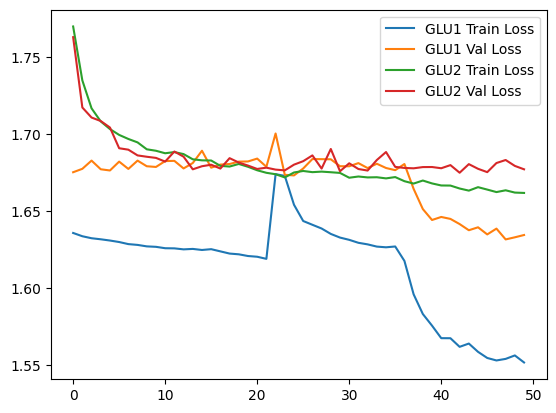

In [ ]:
import matplotlib.pyplot as plt

plt.plot(GLU1_train_loss_list, label='GLU1 Train Loss')
plt.plot(GLU1_val_loss_list, label='GLU1 Val Loss')
plt.plot(GLU2_train_loss_list, label='GLU2 Train Loss')
plt.plot(GLU2_val_loss_list, label='GLU2 Val Loss')
plt.legend()
plt.legend()

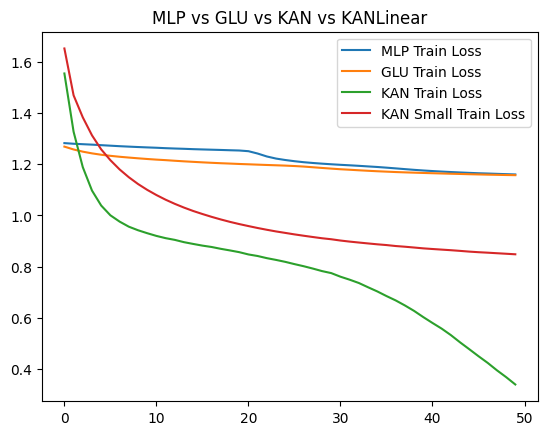

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MLP_train_loss_list, label='MLP Train Loss')
plt.plot(GLU_train_loss_list, label='GLU Train Loss')
plt.plot(KAN_train_loss_list, label='KAN Train Loss')
plt.plot(KAN_small_loss_list, label='KAN Small Train Loss')
plt.legend()
plt.title('MLP vs GLU vs KAN vs KANLinear')
plt.show()

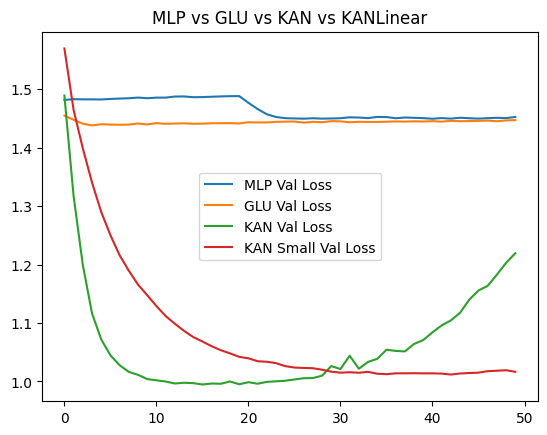

In [ ]:
plt.plot(MLP_val_loss_list, label='MLP Val Loss')
plt.plot(GLU_val_loss_list, label='GLU Val Loss')
plt.plot(KAN_val_loss_list, label='KAN Val Loss')
plt.plot(KAN_small_val_loss_list, label='KAN Small Val Loss')
plt.legend()
plt.title('MLP vs GLU vs KAN vs KANLinear')
plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, X_val, y_val):
    model.eval()

    y_pred = model(X_val)
    label_pred = torch.argmax(y_pred, dim=1).cpu()
    label_true = torch.argmax(y_val, dim=1).cpu()

    cm = confusion_matrix(label_true, label_pred)
    acc = accuracy_score(label_true, label_pred)
    f1 = f1_score(label_true, label_pred, average='macro')
    precision = precision_score(label_true, label_pred, average='macro')
    recall = recall_score(label_true, label_pred, average='macro')

    return cm, acc, f1, precision, recall

In [ ]:
cm, acc, f1, precision, recall = evaluate_model(MLP_model, X_val, y_val)
print('Confusion matrix\n', cm)
print('Accuracy:', acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Confusion matrix
 [[ 679  112  152  149   69   36]
 [ 165 1470  476  323  104   57]
 [ 132  335 1866  410   63   56]
 [ 112  344  379 1074   82   68]
 [  78   92   67   72  638    5]
 [  26   64   83   83   16  167]]
Accuracy: 0.5833333333333334
F1 score: 0.5618127843068155
Precision: 0.5649230989189075
Recall: 0.5596512646515532


In [ ]:
cm, acc, f1, precision, recall = evaluate_model(GLU_model, X_val, y_val)
print('Confusion matrix\n', cm)
print('Accuracy:', acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Confusion matrix
 [[ 675  117  164  138   74   29]
 [ 180 1492  465  326   83   49]
 [ 152  346 1903  353   58   50]
 [ 109  348  404 1060   76   62]
 [  78   98   52   68  649    7]
 [  31   70   91   69   16  162]]
Accuracy: 0.58798495645289
F1 score: 0.5656429576719113
Precision: 0.5715536518798612
Recall: 0.5615562412897966


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
cm, acc, f1, precision, recall = evaluate_model(KAN_model, X_val, y_val)
print('Confusion matrix\n', cm)
print('Accuracy:', acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Confusion matrix
 [[ 634  145  193  132   63   30]
 [ 180 1548  447  292   94   34]
 [ 134  410 1817  400   61   40]
 [ 139  404  422  963   82   49]
 [  93  106   69   63  618    3]
 [  26   77   96   69   16  155]]
Accuracy: 0.567596991290578
F1 score: 0.5469400967857991
Precision: 0.5599946393922098
Recall: 0.5384995986253843


In [ ]:
cm, acc, f1, precision, recall = evaluate_model(KAN_model_small, X_val, y_val)
print('Confusion matrix\n', cm)
print('Accuracy:', acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Confusion matrix
 [[ 662  123  188  154   51   19]
 [ 166 1600  441  292   79   17]
 [ 130  352 1933  370   46   31]
 [ 107  365  391 1083   66   47]
 [  87  101   70   53  639    2]
 [  25   75   96   71   13  159]]
Accuracy: 0.6013460015835312
F1 score: 0.5810803980950312
Precision: 0.603684680314329
Recall: 0.5674016995058604
